/Users/rob/anaconda3/envs/daq/lib/python3.6/site-packages/odo/backends/pandas.py:102: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))



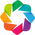

In [1]:
import copy
import numpy as np
import pandas as pd
import holoviews as hv
from daq.pico import CSV
from scipy.optimize import fmin, minimize, basinhopping, fsolve
from easier import ParamState, shade, Item
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge
from harmonic import Harmonic
hv.extension('bokeh')

In [2]:
%opts Curve [width=400, height=400 show_grid=True tools=['hover']]


In [3]:
# create a small normalizer function
def normalizer(y, scale=None, return_scale=False):
    if scale is None:
        scale = 1. / (np.sqrt(2) * np.std(y))
    if return_scale:
        return scale * y, scale
    else:
        return scale * y


def demeaner(df):
    for col in df.columns:
        if col == 't':
            continue
        df.loc[:, col] = df.loc[:, col] - df.loc[:, col].mean()
    return df


In [4]:
file_name, fundamental_freq = './data_20171220/20171220-0003.csv', 20
# file_name, fundamental_freq = './data_20171220/20171220-0004.csv', 20
# file_name, fundamental_freq = './data_20171220/20171220-0005.csv', 20
# file_name, fundamental_freq = './data_20171220/20171220-0001.csv', 20  # air



In [5]:
params = ParamState(
    alpha=None,
    method='lassocv',
    num_freqs=3,
    simple_freq_fit=True,
    periods=2,
    max_sample_freq=1e7,
    normalize=True
)
params

,val,const
alpha,None,
max_sample_freq,1e+07,
method,lassocv,
normalize,True,
num_freqs,3,
periods,2,
simple_freq_fit,True,


In [6]:
def get_fit_frame(file_name, fundamental_freq, params):
    df = CSV(file_name, a='sig_gen', b='res_volt', c='sec_volt', max_sample_freq=params.max_sample_freq).df
    df = demeaner(df)  
    
    # refine the guess of the fundamental frequency
    h = Harmonic(freq=fundamental_freq, num_freqs=1)
    f0 = h.refine_frequency(df.t, df.sig_gen, simple=params.simple_freq_fit).f0
    
    # initialize harmonic objects for resistor and secondary voltages
    h_resistor = Harmonic(freq=f0, num_freqs=params.num_freqs)
    h_secondary = Harmonic(freq=f0, num_freqs=params.num_freqs)
    
    h_resistor.fit(df.t, df.res_volt, method=params.method, alpha=params.alpha)
    h_secondary.fit(df.t, df.sec_volt, method=params.method, alpha=params.alpha)
    
    h_actual_deriv = h_secondary.derivative()
    h_expected_deriv = -h_resistor.derivative(2)

    if params.normalize:
        res_fit = h_resistor.predict(df.t)
        sec_fit = h_secondary.predict(df.t)
        _, res_scale = normalizer(res_fit, return_scale=True)
        _, sec_scale = normalizer(sec_fit, return_scale=True)
    
    
    if params.normalize:
        df.loc[:, 'res_volt'] = res_scale * df.res_volt
        df.loc[:, 'sec_volt'] = sec_scale * df.sec_volt
        
    t_ref = df.t.iloc[len(df) // 2]
    df = df[(df.t >= t_ref) & (df.t < t_ref + params.periods * h.period)].reset_index(drop=True)
    
        
    actual_zero = fsolve(h_actual_deriv.predict, t_ref)
    expected_zero = fsolve(h_expected_deriv.predict, actual_zero)
    delta = actual_zero - expected_zero

    actual_secondary = h_secondary.predict(df.t)
    expected_secondary = -h_resistor.derivative().predict(df.t - delta)
    if params.normalize:
        actual_secondary = normalizer(actual_secondary)
        expected_secondary = normalizer(expected_secondary)
    
    kwargs = dict(
        t=df.t,
        actual=actual_secondary,
        expected=expected_secondary,
    )

    df_fit = pd.DataFrame(kwargs, columns=kwargs.keys())
    return df, df_fit    

    

df, dff = get_fit_frame(file_name, fundamental_freq, params)
display(df.head())
display(dff.head())

,t,sig_gen,res_volt,sec_volt
0,5.00002,-0.393836,-1.413742,0.583110
1,5.00004,-0.394813,-0.812551,0.514042
2,5.00006,-0.388373,-1.032557,0.456805
3,5.00008,-0.387732,-1.177293,0.476197
4,5.00010,-0.392066,-1.066851,0.511365


,t,actual,expected
0,5.00002,0.496910,0.511955
1,5.00004,0.494702,0.509818
2,5.00006,0.492491,0.507678
3,5.00008,0.490276,0.505535
4,5.00010,0.488058,0.503388


In [9]:
(
    hv.Curve((dff.actual, dff.expected), kdims=['actual'], vdims=['expected'])
    + hv.Curve((dff.actual, dff.expected - dff.actual), kdims=['actual'], vdims=['expected - actual'])
    + (
        hv.Curve((df.t, df.sec_volt), label='data', kdims=['time'], vdims=['amplitude'])
        * hv.Curve((dff.t, dff.actual), label='actual')
        * hv.Curve((dff.t, dff.expected), label='expected')
    )
    
).cols(1)

:Layout
   .Curve.I   :Curve   [actual]   (expected)
   .Curve.II  :Curve   [actual]   (expected - actual)
   .Overlay.I :Overlay
      .Curve.Data     :Curve   [time]   (amplitude)
      .Curve.Actual   :Curve   [x]   (y)
      .Curve.Expected :Curve   [x]   (y)